In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src import efficient_convnet_for_semseg
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.


In [2]:
weights_file = 'models/Efficient-ConvNet-for-SemSeg-CamVid11.h5'

In [3]:
# the batch size for training
batch_size = 12
# use a size with an 8x8 window of random crop augmentation. the dimensions
# must be divisible by 8 for this network
crop_size = (352, 472)

# Training

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size, 
    ignored_labels=['Void'],
    horizontal_flip=True,
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


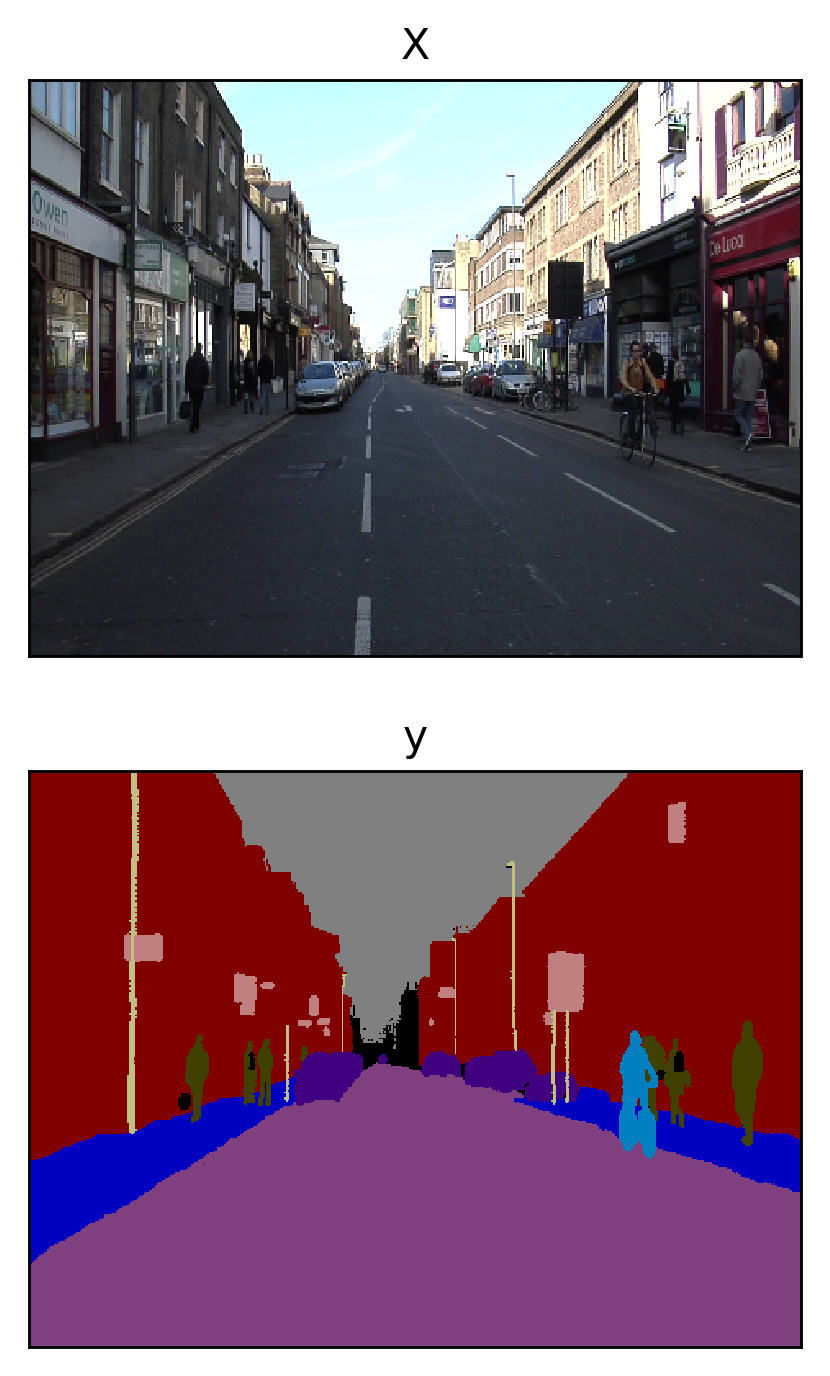

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
# TODO: update to use their class weighting function instead of the class mask
model = efficient_convnet_for_semseg.efficient_convnet_for_semseg((*crop_size, 3), 
                                                                  camvid11.n, 
                                                                  camvid11.class_mask)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 352, 472, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 472, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 176, 236, 13) 364         pixel_norm[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 176, 236, 3)  0           pixel_norm[0][0]                 
__________________________________________________________________________________________________
concatenat

In [ ]:
# create the callbacks for the training procedure
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5),
    ModelCheckpoint(weights_file, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

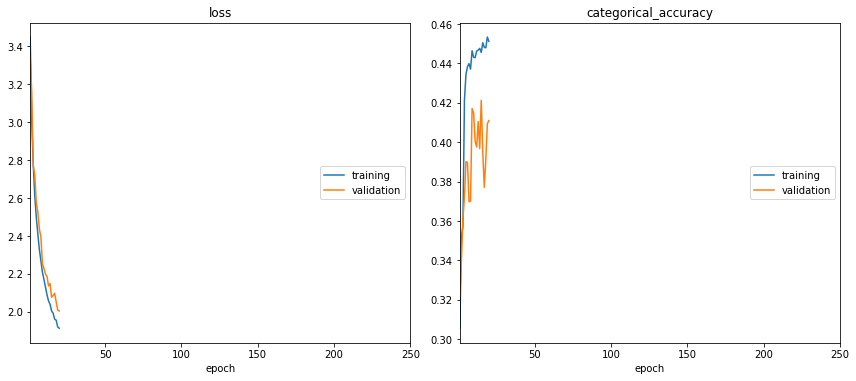

In [ ]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=250,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
history_to_results(history)

## Load Best Model

In [ ]:
model.load_weights(weights_file)

# Test Metrics

In [ ]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics.to_csv(weights_file + '.csv')
metrics

In [ ]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

# Qualitative Results

### Train

In [ ]:
X, y, p = predict.predict(model, generators['train'], camvid11)

In [ ]:
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[3], y=y[3], y_pred=p[3], order=['X', 'y', 'y_pred'])

### Validation

In [ ]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

In [ ]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

In [ ]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

In [ ]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/0.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/1.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/2.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/3.png', transparent=True, bbox_inches='tight')

# Video

In [ ]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/segnet/{}'.format(video_file)

In [ ]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict)